In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import joblib

# 1. Data Loading and Preparation
def load_time_series_data():
    """Load data where each test has one time series of temperatures"""
    summary_df = pd.read_csv('all.csv')
    test_data = []
    
    # Load each test file and its parameters
    for i in range(1, 26):
        try:
            filename = f'csv_ave/{i}_ave.csv'
            df = pd.read_csv(filename, header=1)
            test_params = summary_df.iloc[i-1][['Fb_set\n[kN]', 'v_set\n[km/h]', 'μ_m']].values
            temperature_series = df.iloc[:, 3].values  # Assuming temperature is in column 3
            
            test_data.append({
                'Fb_set': test_params[0],
                'v_set': test_params[1],
                'μ_m': test_params[2],
                'temperature_series': temperature_series,
                'series_length': len(temperature_series)
            })
        except FileNotFoundError:
            continue
    
    return test_data

# Load data
test_data = load_time_series_data()

# Find the maximum length to pad/truncate all series to same length
max_length = max([d['series_length'] for d in test_data])

# Prepare data arrays
X = []
y = []

for test in test_data:
    # Input features
    X.append([test['Fb_set'], test['v_set'], test['μ_m']])
    
    # Temperature series (pad shorter series with last value)
    temp_series = test['temperature_series']
    if len(temp_series) < max_length:
        padded = np.pad(temp_series, 
                       (0, max_length - len(temp_series)), 
                       mode='edge')  # Pad with last value
    else:
        padded = temp_series[:max_length]  # Truncate if longer
    y.append(padded)

X = np.array(X)
y = np.array(y)

In [2]:
print(X.shape)
print(y.shape)

(12, 3)
(12, 43663)


In [3]:
print(X)

[[ 23.     50.      0.408]
 [ 23.     80.      0.383]
 [ 23.    120.      0.374]
 [ 23.    160.      0.376]
 [ 23.    200.      0.381]
 [ 23.    250.      0.383]
 [ 23.     50.      0.397]
 [ 23.     80.      0.379]
 [ 23.    120.      0.38 ]
 [ 23.    160.      0.387]
 [ 23.    200.      0.396]
 [ 23.    250.      0.392]]


In [4]:
# Split into train and test sets (keeping each test's series together)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

# Normalize features
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Normalize targets (per time step)
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# 2. Model Definition
def build_time_series_model(input_shape, output_length):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=input_shape),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(8, activation='relu'),
        layers.Dense(output_length)  # Output matches time series length
    ])
    
    optimizer = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
    return model

model = build_time_series_model((X_train.shape[1],), max_length)
model.summary()

# 3. Training Configuration
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True)

checkpoint = ModelCheckpoint(
    'best_time_series_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min')

# 4. Train the Model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping, checkpoint],
    verbose=1)

/Users/yanjun/Documents/apps/miniconda3/envs/dd2421/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43663)          │       392,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 395,567 (1.51 MB)

 Trainable params: 395,567 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 0.9154 - mae: 0.8160

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - loss: 0.9154 - mae: 0.8160 - val_loss: 1.3413 - val_mae: 1.0611
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9138 - mae: 0.8151 - val_loss: 1.3454 - val_mae: 1.0603
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9129 - mae: 0.8142 - val_loss: 1.3458 - val_mae: 1.0578
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9086 - mae: 0.8118

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.9086 - mae: 0.8118 - val_loss: 1.3399 - val_mae: 1.0530
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9101 - mae: 0.8128

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.9101 - mae: 0.8128 - val_loss: 1.3295 - val_mae: 1.0472
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9029 - mae: 0.8080

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.9029 - mae: 0.8080 - val_loss: 1.3115 - val_mae: 1.0389
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8985 - mae: 0.8049

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8985 - mae: 0.8049 - val_loss: 1.2833 - val_mae: 1.0272
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8932 - mae: 0.8012

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8932 - mae: 0.8012 - val_loss: 1.2446 - val_mae: 1.0119
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8907 - mae: 0.8040

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.8907 - mae: 0.8040 - val_loss: 1.1991 - val_mae: 0.9931
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8592 - mae: 0.7760

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.8592 - mae: 0.7760 - val_loss: 1.1349 - val_mae: 0.9664
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8664 - mae: 0.7781

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8664 - mae: 0.7781 - val_loss: 1.0556 - val_mae: 0.9319
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8372 - mae: 0.7593

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.8372 - mae: 0.7593 - val_loss: 0.9575 - val_mae: 0.8880
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8226 - mae: 0.7465

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.8226 - mae: 0.7465 - val_loss: 0.8449 - val_mae: 0.8331
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8068 - mae: 0.7274

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.8068 - mae: 0.7274 - val_loss: 0.7196 - val_mae: 0.7644
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8035 - mae: 0.7366

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.8035 - mae: 0.7366 - val_loss: 0.6568 - val_mae: 0.7255
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7780 - mae: 0.7200

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7780 - mae: 0.7200 - val_loss: 0.6177 - val_mae: 0.6984
Epoch 17/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8022 - mae: 0.7484

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8022 - mae: 0.7484 - val_loss: 0.5745 - val_mae: 0.6669
Epoch 18/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7787 - mae: 0.7357

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7787 - mae: 0.7357 - val_loss: 0.5652 - val_mae: 0.6568
Epoch 19/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8017 - mae: 0.7641 - val_loss: 0.5977 - val_mae: 0.6730
Epoch 20/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7922 - mae: 0.7440 - val_loss: 0.6371 - val_mae: 0.6898
Epoch 21/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7124 - mae: 0.6837 - val_loss: 0.6914 - val_mae: 0.7099
Epoch 22/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7779 - mae: 0.7353 - val_loss: 0.7735 - val_mae: 0.7372
Epoch 23/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7211 - mae: 0.6873 - val_loss: 0.8194 - val_mae: 0.7438
Epoch 24/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6531 - mae: 0.6413 - val_loss: 0.8249 - val_mae: 0.7273
Epoch 25/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7475 - mae: 0.7042 - val_loss: 0.8119 - val_mae: 0.7014
Epoch 26/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7142 - mae: 0.65

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7224 - mae: 0.6644 - val_loss: 0.4770 - val_mae: 0.5038
Epoch 30/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7007 - mae: 0.6628 - val_loss: 0.4915 - val_mae: 0.5186
Epoch 31/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7104 - mae: 0.7000 - val_loss: 0.5260 - val_mae: 0.5468
Epoch 32/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6772 - mae: 0.6647 - val_loss: 0.5561 - val_mae: 0.5739
Epoch 33/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6986 - mae: 0.6958 - val_loss: 0.6196 - val_mae: 0.6213
Epoch 34/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6724 - mae: 0.6549 - val_loss: 0.7219 - val_mae: 0.6880
Epoch 35/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.7616 - mae: 0.7268 - val_loss: 0.7792 - val_mae: 0.7216
Epoch 36/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6069 - mae: 0.5824 - val_loss: 0.7943 - val_mae: 0.7345
Epoch 37/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6574 - mae: 0.60


Evaluating on test data:
Test MSE: 5.5886, Test MAE: 1.1390
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/Users/yanjun/Documents/apps/miniconda3/envs/dd2421/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


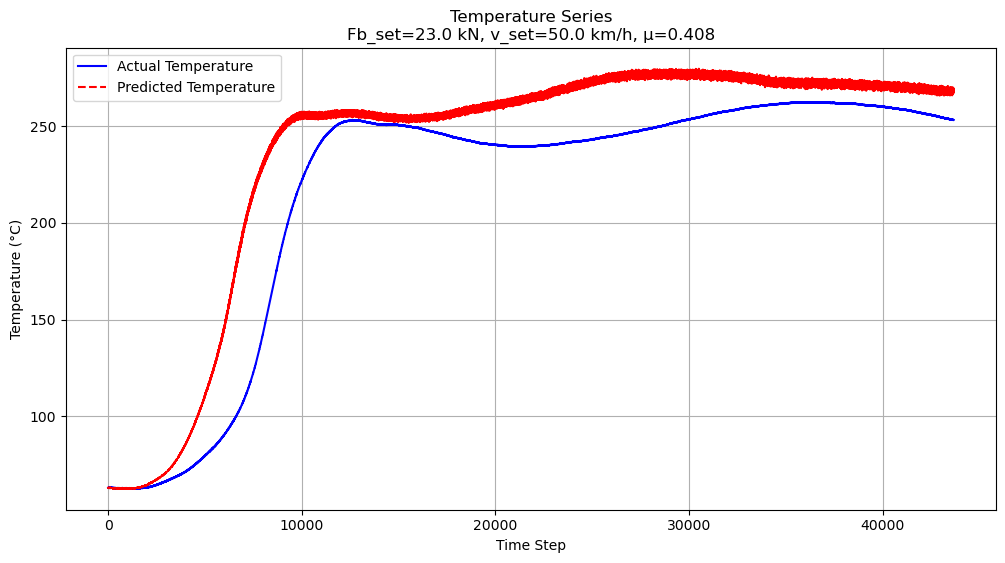

In [5]:
# 5. Evaluate the Model
print("\nEvaluating on test data:")
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Save the model and scalers
model.save('brake_temp_time_series_model.keras')
joblib.dump(scaler_X, 'scaler_X_time_series.pkl')
joblib.dump(scaler_y, 'scaler_y_time_series.pkl')

# 6. Prediction Function
def predict_temperature_series(Fb_set, v_set, mu_m):
    """Predict the full temperature time series for given parameters"""
    # Load model and scalers
    model = keras.models.load_model('brake_temp_time_series_model.keras')
    scaler_X = joblib.load('scaler_X_time_series.pkl')
    scaler_y = joblib.load('scaler_y_time_series.pkl')
    
    # Prepare input
    input_data = np.array([[Fb_set, v_set, mu_m]])
    input_data = scaler_X.transform(input_data)
    
    # Predict
    prediction = model.predict(input_data)
    prediction = scaler_y.inverse_transform(prediction)
    
    return prediction[0]  # Return the full time series

# 7. Visualization
def plot_temperature_series(Fb_set, v_set, mu_m):
    """Plot the predicted temperature series"""
    # Get prediction
    pred_temp = predict_temperature_series(Fb_set, v_set, mu_m)
    
    # Find the actual data if available
    actual_temp = None
    for test in test_data:
        if (test['Fb_set'] == Fb_set and 
            test['v_set'] == v_set and 
            test['μ_m'] == mu_m):
            actual_temp = test['temperature_series']
            break
    
    # Create time axis
    time_steps = np.arange(len(pred_temp))
    
    # Plot
    plt.figure(figsize=(12, 6))
    if actual_temp is not None:
        plt.plot(np.linspace(0, len(pred_temp), len(actual_temp)), 
                actual_temp, 'b-', label='Actual Temperature')
    plt.plot(time_steps, pred_temp, 'r--', label='Predicted Temperature')
    
    plt.title(f'Temperature Series\nFb_set={Fb_set} kN, v_set={v_set} km/h, μ={mu_m}')
    plt.xlabel('Time Step')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
if len(test_data) > 0:
    sample_test = test_data[0]
    plot_temperature_series(sample_test['Fb_set'], 
                          sample_test['v_set'], 
                          sample_test['μ_m'])